### Currently defect application of kmeans_in_time_sin to TIMIT data

In [ ]:
import os, sys

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from matplotlib import gridspec
from experiments.helpers.experiment_helpers import *
from lib.plotting.plot_0 import *

import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
from dataset.loading import DataLoader
from lib.esn import ESN
import pandas as pd

np.random.seed(0)
random.seed(0)
warnings.filterwarnings("ignore")

In [1]:

import pickle as pkl
import gc
from lib.conceptors import *
from lib.esn import ESN
from lib.helpers import *
import warnings
warnings.filterwarnings("ignore")

###-------------- Collecting Training Features -------------------

save = True

data_dir = '../../dataset/'
cache_dir = '../../cache/'
dl = DataLoader(data_dir, cache_dir)


dr = []
speakers = []
long_version = True
n_mels = 13
delta = False
delta_delta = False
subsamples = 10

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers)+"_"+path_option

features,labels,oversamplings = dl.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    subsamples=subsamples,path_option=path_option)

In [ ]:
# init reservoir
import random
random.seed(0)
np.random.seed(0)
#t_max = 1000
t_test = 50
t_washout = 0 # number of washout steps
aperture = 5
XorZ = "X"

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 50,
    "W_in_scale": 1.1,
    "b_scale": .44,
    "spectral_radius": 2.57,
    "weights": .1
}

esn = ESN(esn_params)

esn_states = [ esn.run(feature.T, XorZ=XorZ) for feature in features ]

In [4]:
n = 1000
delta=False

fv, lv, sr = dl.collectFeatures(
    ft="Test",n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,n=n,
    path_option=path_option+"_flat_"+str(n)
)

X, _ = esn.run_X(fv.T, t_washout)

-from output
---- success


NameError: name 'esn' is not defined

In [3]:
from enum import Enum

class Method(Enum):
    RANDOM = 0
    RANGES = 1
    EQUAL_SPLIT = 2

def assign_to_clusters(nb_points, nb_clusters, method=Method.EQUAL_SPLIT, limits=[]):
    """
    Assigns points to conceptors according to one of several assignment methods
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    if method == Method.RANDOM or method == Method.EQUAL_SPLIT:
        points = [ x for x in range(nb_points) ]
        if method == Method.RANDOM:
            np.random.shuffle(points)
        for i in range(nb_clusters):
            assignments[i] = points[i*int(nb_points/nb_clusters):(i+1)*int(nb_points/nb_clusters)]
    elif method == Method.RANGES:
        mark = 0
        for i in range(nb_points):
            if i in limits:
                mark += 1
            assignments[mark].append(i)
    return assignments

def assign_fuzzy_to_clusters(nb_points, nb_clusters, transition_time):
    """
    Distributes points over clusters smoothly changing float membership
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    mean_length = int(nb_points/nb_clusters)
    current = -1
    for t in range(nb_points):
        if not t % mean_length:
            current += 1
        for i in range(nb_clusters):
            if i == current:
                if t % mean_length > mean_length - transition_time and not i + 1 == nb_clusters:
                    assignments[i].append(1 - (t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
                else:
                    assignments[i].append(1)
            elif i == current + 1 and t % mean_length > mean_length - transition_time:
                assignments[i].append((t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
            else:
                assignments[i].append(0)
    return assignments


In [4]:

from scipy.ndimage import gaussian_filter

def kmeans(X, nb_conceptors, method, limits, aperture, max_epochs=100, sigma=1, plot=None):
    """
    Kmeans algorithm, adapted to conceptors
    """
    print("K-means")
    # Initial assignments and initial conceptors
    nb_points = X.shape[1]
    new_assignments = assign_to_clusters(nb_points, nb_conceptors, method, limits)
    # Training loop
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        # recompute centroids based on subset of assigned state
        Cs = [ compute_c(X[:,assignments], aperture) for assignments in new_assignments ]
        Ns = Ns_from_Cs(Cs)
        #print("- optimizing +")
        Cs = optimize_apertures(Cs)
        #print("- optimizing -")
        Ns = optimize_apertures(Ns)
        if plot != None and epoch == 0:
            plot.add_new_assignment_plot(new_assignments)
        elif plot:
            plot.add_new_assignment_plot(new_assignments,None)
        
        # recompute assignments by find the closest conceptor for each of the state points
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(nb_conceptors) ]
        
        Es = np.zeros((nb_conceptors, nb_points))
        for t in range(nb_points):
            Es[:,t] = np.array( evidences_for_Cs_z(X[:,t], Cs, Ns) )
        
        for c in range(nb_conceptors):
            Es[c,:] = gaussian_filter(Es[c,:], order=0, sigma=sigma)
        
        for t in range(nb_points):
            conceptor_index = np.argmax(Es[:,t])
            new_assignments[ conceptor_index ].append(t)

        # stop if converged
        for new_assignment, old_assignment in zip(new_assignments, old_assignments):
            if set(new_assignment) == set(old_assignment):
                print("Converged")
                return Cs, Ns, new_assignments

    return Cs, Ns, new_assignments

In [ ]:
delta=False
delta_delta=False

fv, lv, sr = dl.collectFeatures(
    ft="Train",n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=[],dr=[],sentence="SA1",n=n,
    path_option="1234"
)

In [ ]:
t_washout = 0 # number of washout steps
aperture = 5

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 40,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5
}

esn = ESN(esn_params)
X, _ = esn.run_X(fv.T, fv.shape[0], t_washout)

In [5]:
n = 6000
delta=False

fv, lv, sr = fc.collectFeatures(
    ft="Test",n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=["MGMM0"],dr=dr,n=n,
    path_option=path_option+"_flat_"+str(n)
)
truth = {}
for t in range(len(lv)):
    if lv[t] not in truth.keys():
        truth[lv[t]] = []
    truth[lv[t]].append(t)

-from output
---- success


In [168]:
t_washout = 0 # number of washout steps
aperture = 5

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 70,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5
}

esn = ESN(esn_params)
X, _ = esn.run_X(fv.T, fv.shape[0], t_washout)

In [ ]:

plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (7,7)
plot = Plot()
plot.add_new(p)
plot.add_new_assignment_plot(correct_assignments)

Cs = [ compute_c(X[:,assignments], aperture) for assignments in correct_assignments ]
Ns = Ns_from_Cs(Cs)
#print("- optimizing +")
Cs = optimize_apertures(Cs)
#print("- optimizing -")
Ns = optimize_apertures(Ns)

Es = np.zeros((len(correct_assignments), p.shape[0]))
for t in range(p.shape[0]):
    Es[:,t] = np.array( evidences_for_Cs_z(X[:,t], Cs, Ns) )

Finals = [ [] for _ in range(len(correct_assignments))]
for i in range(len(correct_assignments)):
    Es[i,:] = gaussian_filter(Es[i,:], order=0, sigma=20)

for t in range(p.shape[0]):
    Finals[np.argmax(Es[:,t])].append(t)

plot.add_new_assignment_plot(Finals)
plot.finalize()

In [182]:
def gen_signal(n, period, amplitude):
    """
    Generates a sin wave
    """
    ts = np.arange(n)
    data = amplitude * np.sin(2 * np.pi * (1/period) * ts)
    return data

def gen_square(n, period):
    ts = np.zeros(n)
    for t in range(n):
        ts[t] = -1+2*(t % (period * 2) < period)
    return ts
t_max = 500
print("Generating signals")
l = []
for i in range(5):
    T1 = np.random.randint(5,25)
    A1 = np.random.randint(1,5)
    #T2 = np.random.randint(5,25)
    #A2 = np.random.randint(1,5)
    s = gen_signal(t_max, T1, A1)# + gen_signal(t_max, T2, A2)
    l.append(s)
    
p1 = gen_signal(t_max, 20, 1) * gen_signal(t_max, 11, 1)
p3 = gen_square(t_max, 11)
p4 = gen_square(t_max, 7)
#l = [p1, p2, p3]
maps=[]
data=[]
for _ in range(15):
    maps.append(np.random.randint(len(l)))
mean = 0
std = .1
for x in maps:
    signal = l[x]
    gaus_noise = np.random.normal(mean, std, signal.shape)
    res = signal + gaus_noise
    data.append(res)
p = np.concatenate(data)
correct_assignments = [ [] for _ in range(len(l)) ]
tracker = 0
for x in maps:
    correct_assignments[x] += range(tracker,tracker+len(l[x]))
    tracker += len(l[x])

Generating signals


(7500,)


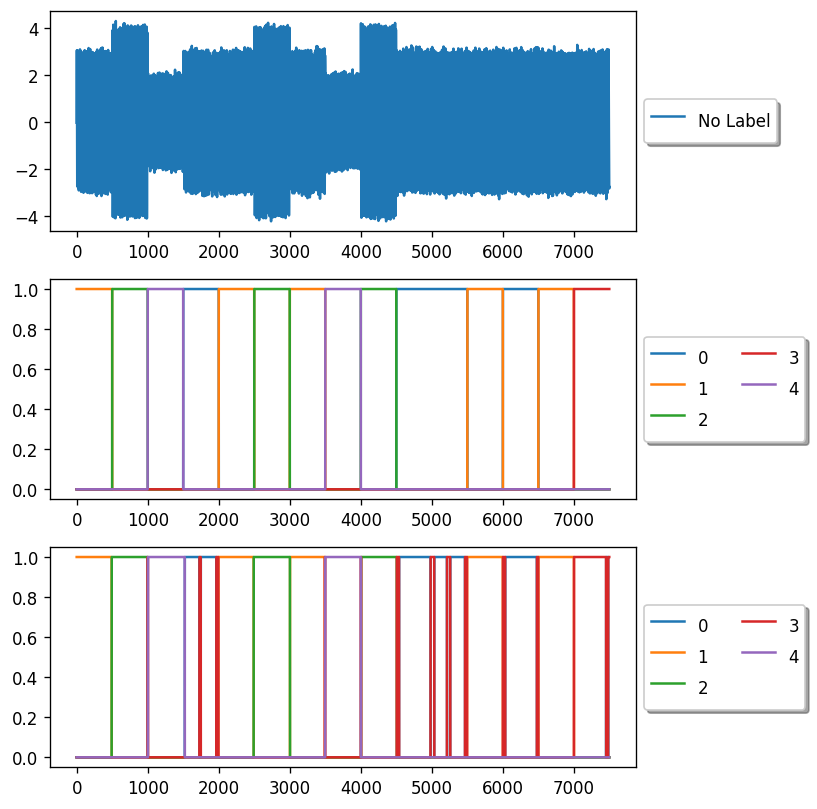

In [183]:

plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (7,7)
plot = Plot()
plot.add_new(p)
plot.add_new_assignment_plot(correct_assignments)

t_washout = 0 # number of washout steps
aperture = 5

esn_params = {
    "in_dim": 1,
    "out_dim": 1,
    "N": 50,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5
}

print(p.shape)
esn = ESN(esn_params)
X, _ = esn.run_X(p.T, t_washout, p.shape[0])
Cs = [ compute_c(X[:,assignments], aperture) for assignments in correct_assignments ]
Ns = Ns_from_Cs(Cs)
#print("- optimizing +")
Cs = optimize_apertures(Cs)
#print("- optimizing -")
Ns = optimize_apertures(Ns)

Es = np.zeros((len(correct_assignments), p.shape[0]))
for t in range(p.shape[0]):
    Es[:,t] = np.array( evidences_for_Cs_z(X[:,t], Cs, Ns) )

Finals = [ [] for _ in range(len(correct_assignments))]
for i in range(len(correct_assignments)):
    Es[i,:] = gaussian_filter(Es[i,:], order=0, sigma=20)

for t in range(p.shape[0]):
    Finals[np.argmax(Es[:,t])].append(t)

plot.add_new_assignment_plot(Finals)
plot.finalize()

K-means
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
Converged
0.5840778770502734
{'W_in_scale': 1.5, 'b_scale': 0.2, 'spectral_radius': 1.5, 'aperture': 5, 'sigma': 10}


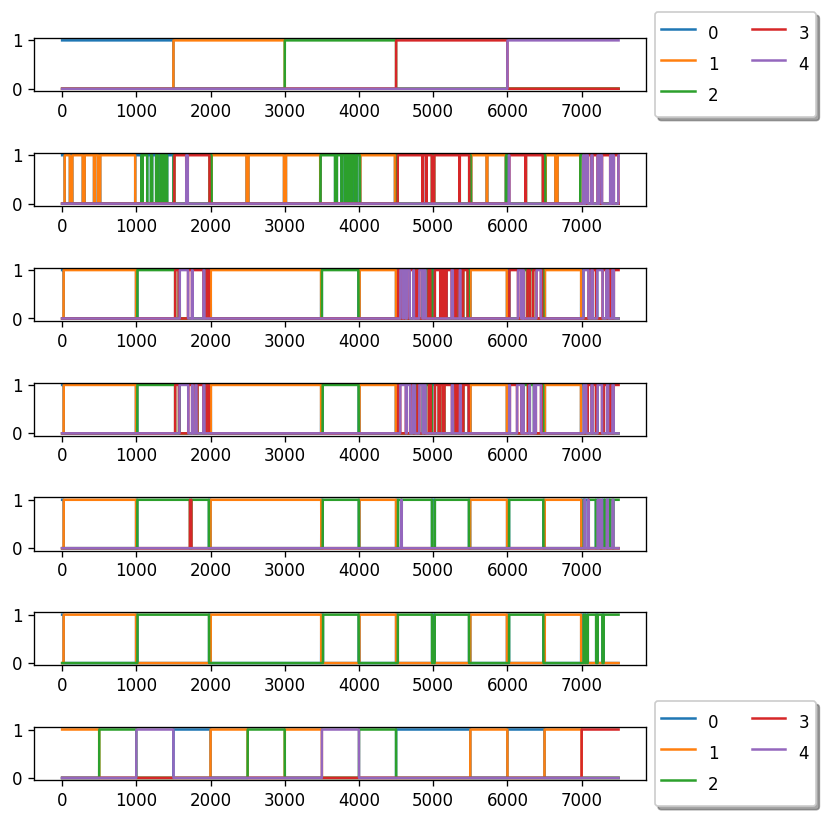

In [184]:
def experiment(X,nb_conceptors,sigma,plot):
    Cs_kmeans, Ns_kmeans, assignments_kmeans = kmeans(X, nb_conceptors=nb_conceptors, method=Method.EQUAL_SPLIT, limits=[],
                                           aperture=aperture, max_epochs=20, sigma=sigma, plot=plot)
    return Cs_kmeans, Ns_kmeans, assignments_kmeans

def test(assignments, phonemes, Cs, Ns):
    overlaps = np.zeros((len(phonemes), len(phonemes))) # (Cs x phonemes)

    for C_idx, assignment in enumerate(assignments):
        for idx in assignment:
            overlaps[C_idx, phonemes.index(lv[idx])] += 1

    dic = {}
    cnt = 0
    for _ in range(len(phonemes)):
        C_idx, phoneme_idx = np.unravel_index(overlaps.argmax(), overlaps.shape)
        dic[phonemes[phoneme_idx]] = C_idx
        cnt += overlaps[C_idx,phoneme_idx]
        overlaps[C_idx,:] = np.zeros((1,len(phonemes)))
        overlaps[:,phoneme_idx] = np.zeros((len(phonemes),))

    return(cnt/len(fv))

    Cs_final = []
    Ns_final = []
    for phoneme in [p for p in phonemes_kmeans if p in list(dic.keys()) ]:
        Cs_final.append(Cs[dic[phoneme]])
        Ns_final.append(Ns[dic[phoneme]])
    return Cs_final, Ns_final

def test_assignments(assignments, correct_assignments):
    overlaps = np.zeros((len(assignments), len(correct_assignments))) # (Cs x phonemes)

    for i1, assignment in enumerate(assignments):
        for a in assignment:
            for i2, correct_assignment in enumerate(correct_assignments):
                if a in correct_assignment:
                    overlaps[i1, i2] += 1

    dic = []
    cnt = 0
    for _ in range(len(correct_assignments)):
        i1, i2 = np.unravel_index(overlaps.argmax(), overlaps.shape)
        dic.append(i1)
        cnt += overlaps[i1,i2]
        overlaps[i1,:] = np.zeros((1,len(correct_assignments)))
        overlaps[:,i2] = np.zeros((len(assignments),))

    return cnt/max([ max(ass) for ass in assignments if ass != [] ])

plot = Plot()
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (5,11)

def opt(signal, dim):
    t_washout = 0 # number of washout steps
    best_perf = 0
    params = {}
    for aperture in [5]:#[1,3,5,10,20]:
        for W_in_scale in [1.5]:# [.5,1,1.5,2,2.5]:
            for spectral_radius in [1.5]:# [1,1.5,2]:
                for b_scale in [.2]:# [.2,.5,1]:
                    for sigma in [10]:# [3,5,7,10]:
                        esn_params = {
                            "in_dim": dim,
                            "out_dim": dim,
                            "N": 70,
                            "W_in_scale": W_in_scale,
                            "b_scale": b_scale,
                            "spectral_radius": spectral_radius
                            }

                        esn = ESN(esn_params)
                        X, _ = esn.run_X(signal, t_washout, signal.shape[0])
                        Cs_kmeans, Ns_kmeans, assignments_kmeans = experiment(X, len(l), sigma, plot=plot)
                        plot.add_new_assignment_plot(correct_assignments)
                        p = test_assignments(assignments_kmeans, correct_assignments)
                        if best_perf < p:
                            best_perf = p
                            params = {
                                "W_in_scale": W_in_scale,
                                "b_scale": b_scale,
                                "spectral_radius": spectral_radius,
                                "aperture": aperture,
                                "sigma": sigma
                            }
    
    print(best_perf)
    print(params)
    
#opt(fv.T)
opt(p.T, 1)
plot.finalize()